# Example: Run ACS benchmark task

In [1]:
from pathlib import Path
import folktexts
print(f"{folktexts.__version__=}")

folktexts.__version__='0.1.0'


Load environment variables (e.g., API keys):

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

Directory where data is saved or will be saved to (_**change as appropriate**_):

In [3]:
ROOT_DIR = Path("~/").expanduser()
DATA_DIR = ROOT_DIR / "data"
RESULTS_ROOT_DIR = ROOT_DIR / "folktexts-results"
RESULTS_ROOT_DIR.mkdir(parents=True, exist_ok=True)

Set LLM and task name:

In [4]:
MODEL_NAME = "openai/gpt-4o-mini"
TASK_NAME = "ACSIncome"     # ACSIncome -> income prediction

### Construct LLM Classifier
Load task (maps tabular data to text prompts), and configure the `LLMClassifier`:

In [5]:
USE_NUMERIC_QA = True         # Use numeric Q&A prompts
# USE_NUMERIC_QA = False        # Use multiple-choice Q&A prompts

In [6]:
from folktexts.acs import ACSTaskMetadata
task = ACSTaskMetadata.get_task(
    name=TASK_NAME,
    use_numeric_qa=USE_NUMERIC_QA,
)

In [7]:
from folktexts.classifier import WebAPILLMClassifier

llm_clf = WebAPILLMClassifier(
    model_name=MODEL_NAME,
    task=task,
    batch_size=20,
)

### Load Dataset

In [8]:
%%time
from folktexts.acs import ACSDataset
dataset = ACSDataset.make_from_task(
    task=task,
    survey_year="2018",
    subsampling=0.002,
    cache_dir=DATA_DIR,
)
print(f"{dataset.subsampling=}")

Loading ACS data...
dataset.subsampling=0.002
CPU times: user 43.5 s, sys: 10.3 s, total: 53.8 s
Wall time: 54 s


### Example tabular row, prompt, and LLM prediction

In [9]:
X_example, y_example = dataset.sample_n_train_examples(n=1)
X_example

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
2215517,75,1.0,19.0,2,4020.0,54,0,20.0,2,1


In [10]:
prompt_example = llm_clf.encode_row(X_example.iloc[0], question=llm_clf.task.question)
print(prompt_example)

The following data corresponds to a survey respondent. The survey was conducted among US residents in 2018. Please answer the question based on the information provided. The data provided is enough to reach an approximate answer.

Information:
- The age is: 75 years old.
- The class of worker is: Working for a for-profit private company or organization.
- The highest educational attainment is: Some college, 1 or more years, no degree.
- The marital status is: Widowed.
- The occupation is: Cooks.
- The place of birth is: West Virginia.
- The relationship to the reference person in the survey is: The reference person itself.
- The usual number of hours worked per week is: 20 hours.
- The sex is: Female.
- The race is: White.

Question: What is the probability that this person's estimated yearly income is above $50,000 ?
Answer (between 0 and 1): 0.


In [11]:
y_pred_score, *_ = llm_clf.predict_proba(X_example)
y_pred = (y_pred_score >= llm_clf.threshold).astype(int)
print(f"score={y_pred_score[-1]}; pred={y_pred[-1]}; label={y_example.values[0]}")

Computing risk estimates:   0%|          | 0/1 [00:00<?, ?it/s]

score=0.05; pred=0; label=0


### Run Benchmark

**_Note:_** Helper constructors exist at `Benchmark.make_acs_benchmark` and `Benchmark.make_benchmark` that avoid the above boilerplate code.

In [12]:
from folktexts.benchmark import Benchmark
bench = Benchmark(llm_clf=llm_clf, dataset=dataset)

In [13]:
%%time
bench.run(results_root_dir=RESULTS_ROOT_DIR / "gpt-4o-mini");

Computing risk estimates:   0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 6.55 s, sys: 3.78 s, total: 10.3 s
Wall time: 4min 41s


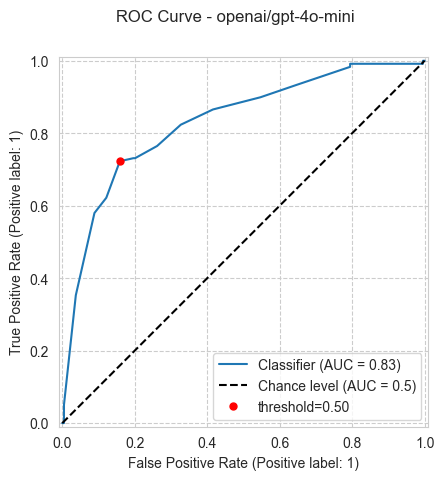

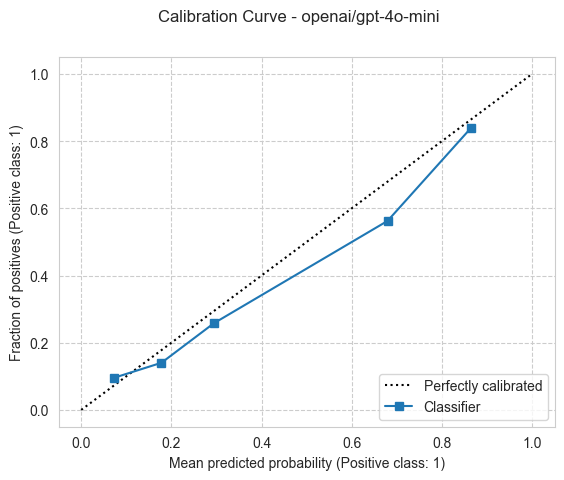

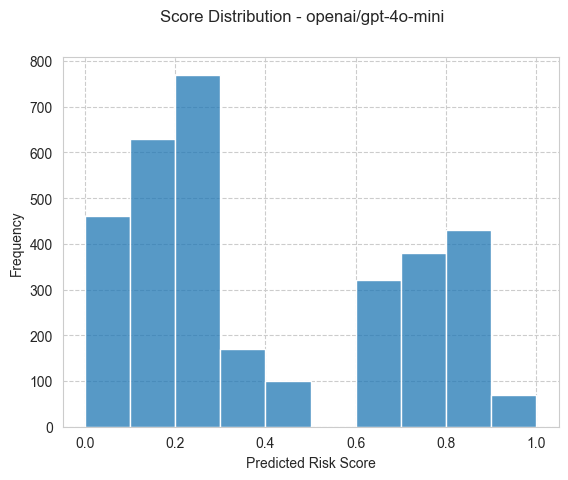

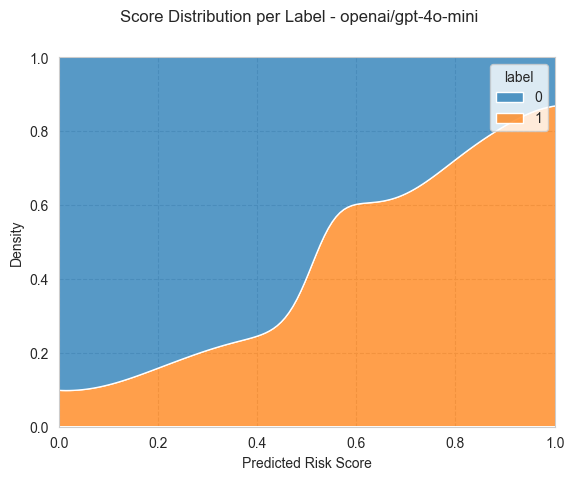

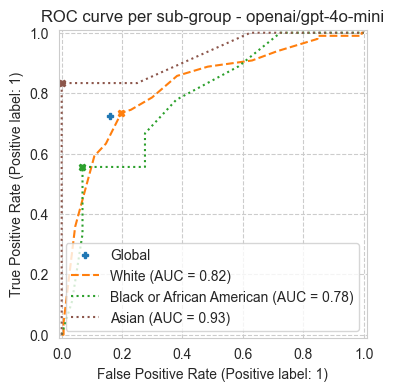

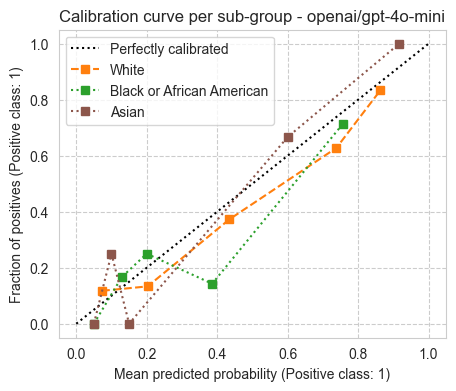

In [14]:
bench.plot_results();

In [17]:
print(f"Accuracy: {bench.results['accuracy']:.3f}")
print(f"Calibration, ECE: {bench.results['ece']:.3f}")
print(f"Fairness, equalized odds: {bench.results['equalized_odds_diff']:.3f}")

from pprint import pprint
pprint(bench.results, depth=1, indent=2)

Accuracy: 0.799
Calibration, ECE: 0.054
Fairness, equalized odds: 0.278
{ 'accuracy': 0.7987987987987988,
  'accuracy_diff': 0.15210084033613447,
  'accuracy_ratio': 0.8361990950226245,
  'balanced_accuracy': 0.7819052854786774,
  'balanced_accuracy_diff': 0.17337164750957856,
  'balanced_accuracy_ratio': 0.8108672936259144,
  'benchmark_hash': 2067127462,
  'brier_score_loss': 0.15524125268127326,
  'config': {...},
  'current_time': '2025.04.08-18.02.48',
  'ece': 0.053879603603603624,
  'ece_quantile': 0.0640231471471472,
  'equalized_odds_diff': 0.2777777777777778,
  'equalized_odds_ratio': 0.0,
  'fnr': 0.2773109243697479,
  'fnr_diff': 0.2777777777777778,
  'fnr_ratio': 0.375,
  'fpr': 0.1588785046728972,
  'fpr_diff': 0.19745222929936307,
  'fpr_ratio': 0.0,
  'log_loss': 0.5828355173643137,
  'model_name': 'openai/gpt-4o-mini',
  'n_negatives': 214,
  'n_positives': 119,
  'n_samples': 333,
  'plots': {...},
  'ppr': 0.36036036036036034,
  'ppr_diff': 0.21971104231166153,
  'pp